## 6.832: Problem Set #3

Due on Friday, March 15, 2019 at 17:00.  See course website for submission details. Use Drake release tag `drake-20190305`, i.e. use this notebook via `./docker_run_notebook.sh drake-20190305.`, or whichever script you need for your platform.

To submit for autograding, upload this file, *and also the inertial_wheel_pendulum.py and inertial_wheel_pendulum_visualizer.py files supplied to you with any modifications you have made*, to the "Problem Set 3, Code Submission" assignment.

---

# 3. Inertial Wheel Pendulum

In this question we'll use a classic underactuated system, the inertial wheel pendulum, to do a case study in bringing together all of these components:

- Stabilization at the upright position using LQR (and how to linearize around a fixed point)
- Finding where is our LQR controller "good", i.e. computing the region of attraction (RoA)
- Swinging up with a simple energy-shaping controller and switching to LQR when inside the RoA

An inertial wheel pendulum is a single-link pendulum with a torque-controlled reaction wheel mounted at its end:

<p align="center">
  <img src="./iwp.png" width="350"/>
</p>

*(Image source Ramirez-Neria, Mario, et al. "On the linear Active Disturbance Rejection Control of the inertia wheel pendulum.")*

The angle of the pendulum is $\theta_1$, and the angle of the reaction wheel is $\theta_2$. The only control input is a (bounded) torque applied to the wheel, $\tau$
$$
{x} = \left[ \begin{array}{c} q
\\ \dot q 
\end{array} \right]
\ \ \ \ \
{q} = \left[ \begin{array}{c}
\theta_1 \\
\theta_2 \end{array} \right]
\ \ \ \ \
{u} = \left[ \tau \right]
\ \ \ \ \
|\tau| \leq \tau_{max}
$$


---

Filling in the manipulator equations for our single-link pendulum,

$$
M \ddot{q} + C(q, \dot{q})\dot{q} = \tau_g(q) + Bu \\
M = \left[ 
\begin{array}{c c} 
  m_1 l_1^2 + m_2 l_2^2 + I_1 + I_2 & I_2 \\
  I_2 & I_2
\end{array}
\right]
\ \ \ \ \ 
C = \left[
\begin{array}{c c}
 0 & 0 \\
 0 & 0
\end{array}
\right]\\
\tau_g(q) = \left[
\begin{array}{c}
 -(m_1 l_1 + m_2 l_2) g sin(\theta_1) \\ 0
\end{array}
\right]
\ \ \ \ \ 
B = \left[
\begin{array}{c}
 0 \\ 1
\end{array}
\right]
$$

$\tau_g(q)$ should look familiar from the simple pendulum case. The effect of $M$ is little trickier, as it includes some interaction terms between $\theta_1$ and $\theta_2$. [This textbook's](http://home.deib.polimi.it/gini/robot/docs/spong.pdf) treatment of the double pendulum (which has fundamentally similar inertia) in Chapter 9 might be of use if you want to dig into this more thoroughly.  

---

## 3.1 Linearization (4 points, 4/4 autograded)

We're interested in stabilizing this system to its upright fixed point at $\theta_1 = \pi$. Let's try using LQR to do this. As a first step, calculate the linearization of these dynamics -- that is, find functions $A(x_f)$ and $B(x_f)$ such that the linear system $\dot x = A(x_f)*\bar{x} + B(x_f)*\bar{u}$, for $\bar{x} = x-x_f$ and $\bar{u} = u-u_f$, approximates our full system in the neighborhood of the fixed point $x_f, u_f$. **Derive those here, and also fill out the corresponding function $GetLinearizedDynamics$ of *inertial_wheel_pendulum.py* to generate these.**

$$
M \ddot{q} + C(q, \dot{q})\dot{q} = \tau_g(q) + Bu \\
\left[ 
\begin{array}{c c} 
  m_1 l_1^2 + m_2 l_2^2 + I_1 + I_2 & I_2 \\
  I_2 & I_2
\end{array}
\right] \ddot{q} = 
\ \ 
\left[
\begin{array}{c}
 -(m_1 l_1 + m_2 l_2) g sin(\theta_1) \\ 0
\end{array}
\right] +
\ \ 
\left[
\begin{array}{c}
 0 \\ 1
\end{array}
\right] u
$$

$$
\left[ 
\begin{array}{c c} 
  m_1 l_1^2 + m_2 l_2^2 + I_1 + I_2 & I_2 \\
  I_2 & I_2
\end{array}
\right]
\ \ 
\left[
\begin{array}{c}
 \ddot{\theta_1} \\ \ddot{\theta_2}
\end{array}
\right]= 
\ \ 
\left[
\begin{array}{c}
 -(m_1 l_1 + m_2 l_2) g sin(\theta_1) \\ 0
\end{array}
\right] +
\ \ 
\left[
\begin{array}{c}
 0 \\ 1
\end{array}
\right] \tau
$$

Linearize about $\theta_1$ = 180 deg, thus $sin(\theta_1) \approx -(\theta_1-180)$

$$
\left[ 
\begin{array}{c c} 
  m_1 l_1^2 + m_2 l_2^2 + I_1 + I_2 & I_2 \\
  I_2 & I_2
\end{array}
\right]
\ \ 
\left[
\begin{array}{c}
 \ddot{\theta_1} \\ \ddot{\theta_2}
\end{array}
\right]= 
\ \ 
\left[
\begin{array}{c}
 (m_1 l_1 + m_2 l_2) g (\theta_1-180) \\ 0
\end{array}
\right] +
\ \ 
\left[
\begin{array}{c}
 0 \\ 1
\end{array}
\right] \tau
$$

Multiply out:
$$(m_1 l_1^2 + m_2 l_2^2 + I_1 + I_2)\ddot{\theta_1} + (I_2)\ddot{\theta_2} = (m_1 l_1 + m_2 l_2) g (\theta_1-180)$$
$$(I_2)\ddot{\theta_1} + (I_2)\ddot{\theta_2} = \tau$$

Subtract second equation from first equation to solve for $\ddot{\theta_1}$:

$$(m_1 l_1^2 + m_2 l_2^2 + I_1)\ddot{\theta_1} = (m_1 l_1 + m_2 l_2) g (\theta_1-180)-\tau$$

$$\ddot{\theta_1} = \frac{(m_1 l_1 + m_2 l_2) g (\theta_1-180)-\tau}{(m_1 l_1^2 + m_2 l_2^2 + I_1)}$$

Substitute into second equation to solve for $\ddot{\theta_2}$:

$$I_2\frac{(m_1 l_1 + m_2 l_2) g (\theta_1-180)-\tau}{(m_1 l_1^2 + m_2 l_2^2 + I_1)} + I_2\ddot{\theta_2} = \tau$$

$$\ddot{\theta_2} = \frac{\tau}{I_2} - \frac{(m_1 l_1 + m_2 l_2) g (\theta_1-180)-\tau}{(m_1 l_1^2 + m_2 l_2^2 + I_1)}$$

Plug into  $\dot x = A(x_f)*\bar{x} + B(x_f)*\bar{u}$:

$$
\left[ 
\begin{array}{c} 
  \dot{\theta_1} \\
  \dot{\theta_2} \\
  \ddot{\theta_1} \\
  \ddot{\theta_2}
\end{array}
\right] = 
\ \ 
\left[
\begin{array}{c c c c}
 0 & 0 & 1 & 0 \\ 
 0 & 0 & 0 & 1 \\ 
 \frac{(m_1 l_1 + m_2 l_2) g}{(m_1 l_1^2 + m_2 l_2^2 + I_1)} & 0 & 0 & 0 \\ 
 - \frac{(m_1 l_1 + m_2 l_2) g}{(m_1 l_1^2 + m_2 l_2^2 + I_1)}  & 0 & 0 & 0
\end{array}
\right] 
\ \ 
\left[ 
\begin{array}{c} 
  \theta_1 - 180 \\
  \theta_2 \\
  \dot{\theta_1} \\
  \dot{\theta_2}
\end{array}
\right]+
\ \ 
\left[ 
\begin{array}{c} 
  0 \\
  0 \\
  \frac{-1}{(m_1 l_1^2 + m_2 l_2^2 + I_1)} \\
  \frac{1}{I_2} + \frac{1}{(m_1 l_1^2 + m_2 l_2^2 + I_1)}
\end{array}
\right]
\ \ 
\left[ 
\begin{array}{c} 
  \tau \\
\end{array}
\right]
$$

In [1]:
# These IPython-specific commands
# tell the notebook to reload imported
# files every time you rerun code. So
# you can modify inertial_wheel_pendulum.py
# and then rerun this cell to see the changes.
%load_ext autoreload
%autoreload 2

from inertial_wheel_pendulum import *
import math
import numpy as np
# Make numpy printing prettier
np.set_printoptions(precision=3, suppress=True)

# Define the upright fixed point here.
uf = np.array([0.])
xf = np.array([math.pi, 0, 0, 0])

# Pendulum params. You're free to play with these,
# of course, but we'll be expecting you to use the
# default values when answering questions, where
# varying these values might make a difference.
m1 = 1. # Default 1
l1 = 1. # Default 1
m2 = 2. # Default 2
l2 = 2. # Default 2
r = 1.0 # Default 1
g = 10  # Default 10
input_max = 10
pendulum_plant = InertialWheelPendulum(
    m1 = m1, l1 = l1, m2 = m2, l2 = l2, 
    r = r, g = g, input_max = input_max)

'''
Code submission for 3.1: 
Edit this method in `inertial_wheel_pendulum.py`
and ensure it produces reasonable A and B
'''
A, B = pendulum_plant.GetLinearizedDynamics(uf, xf)
print("A: ", A)
print("B: ", B)

h2i
('A: ', array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 5.,  0.,  0.,  0.],
       [-5.,  0.,  0.,  0.]]))
('B: ', array([[ 0. ],
       [ 0. ],
       [-0.1],
       [ 1.1]]))


inertial_wheel_pendulum.py:24: DrakeDeprecationWarning: '_DeclareContinuousState' is deprecated and will be removed on or around 2019-06-15. Please call 'DeclareContinuousState' instead.
    Please see `help(pydrake.common.deprecation)` for more information.
  self._DeclareContinuousState(4)


## 3.2 Controllability (3 points, 2/3 autograded)

*Controllability* is an important propery of a linear system -- you can read about it in Chapter 3 of the textbook.

**Write a function to test whether a linear system is controllable, using the function signature below.** (You'll probably want to do this in two steps: building the controllability matrix, and then checking its rank.)

**Is the linearization around the upright controllable? How about the linearization around the fixed point at $\theta = 0$?**

In [2]:
from numpy.linalg import matrix_rank
from numpy.linalg import matrix_power
def is_controllable(A, B):
    #linearization about the upright - is controllable
    #A = np.array([[ 0,  0,  1,  0],  [ 0,  0,  0, 1],  [ 5,  0,  0,  0],  [-5,  0,  0,  0]]) 
    #B = np.array([[ 0 ],  [ 0 ], [-0.1],  [ 1.1]])
    #linearization about the base - is controllable
    #A = np.array([[ 0,  0,  1,  0],  [ 0,  0,  0, 1],  [ -5,  0,  0,  0],  [5,  0,  0,  0]]) 
    #B = np.array([[ 0 ],  [ 0 ], [-0.1],  [ 1.1]])

    n = B.shape[0]
    m = B.shape[1]
    controllability_matrix = np.zeros((n, n*m))
    #from numpy.linalg import matrix_power
    from numpy.linalg import matrix_rank
    #print "subset", controllability_matrix[:,m*3:(m*3+m)]
    #print n
    
    for i in range(0, n):
        
        #print "i", i
        controllability_matrix[:,m*i:(m*i+m)] = np.dot(matrix_power(A,i),B)
        #print "mat", controllability_matrix
    
    #print "subset", controllability_matrix[:,m*3:(m*3+m)]
    #print "A dot B", np.dot(A,B)
    #print np.dot(matrix_power(A,3),B)
    #print np.dot(np.dot(np.dot(A,A),A),B)
    #print controllability_matrix
    if(matrix_rank(controllability_matrix) == n):
        return True
    else:
        return False
    
    '''
    Code submission for 3.2: write code here
    to evaluate the controllability
    of A, B
    '''
    #return False

# Play around with using the function
print "A: ", A
print "B: ", B 
#print controllability_matrix[i,:]
#print np.dot(A**0,B)
print "Is controllable? ", is_controllable(A, B)

A:  [[ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 5.  0.  0.  0.]
 [-5.  0.  0.  0.]]
B:  [[ 0. ]
 [ 0. ]
 [-0.1]
 [ 1.1]]
Is controllable?  True


**Short answer explanation for 3.2. Is the linearization around the upright controllable? How about the linearization around the fixed point at $\theta = 0$?**

Linearization about the upright is controllable, as we can see by running the A and B matricies found in 3.1 through the controllability program. 

To look at $\theta = 0$, we can change to a linearization step to "Linearize about $\theta_1$ = 0 deg, thus $sin(\theta_1) \approx (\theta_1)$" which is a negative sign change in a couple of places in the matricies (in specific, the (2,0) and (3,0) elements of A). Running this through the controllability checker, shows that this position is also controllable, as one would likely predict given that pendulums with no control or external forces settle to $\theta_1$ = 0 deg.

## 3.3 LQR (4 points, 4/4 autograded)

Now that we have a linear system to control, let's try employing LQR to balance the inertial pendulum. Recalling LQR as discussed in class, you need to supply LQR with a couple things:

- Linear system matrices $A$ and $B$
- Symmetric positive semi-definite state cost matrix $Q$
- Symmetric positive definitive input cost matrix $R$
- Another cost matrix $N$ for the off-diagonal terms. (For most of our problems, this is set to zero.)

And it produces an optimal gain matrix $K$ for the optimal controller $\bar{u} = - K\bar{x}$ that minimizes

$$\min_u \int_0^\infty \bar{x}'Q\bar{x} + \bar{u}'R\bar{u} + 2\bar{x}'N\bar{u} dt $$

LQR also returns the cost-to-go matrix $S$, with the optimal cost-to-go taking the form $J(x) = \bar{x}^T S \bar{x}$.

In this problem, we have a complication: we probably don't want to try to control the reaction wheel angle $\theta_2$, as it has no impact on our dynamics. (Check the dynamics as derived above to see this yourself!) Your first instinct might be to set the 2nd row and column of $Q$ to zero: but unfortunately, this doesn't work, as exemplified below.

In [4]:
from pydrake.all import LinearQuadraticRegulator

def create_lqr(A, B):
    Q = np.zeros((4, 4))
    # Not clear what these gains will do,
    # but as long as Q is positive semidefinite
    # this should find a solution.
    Q = np.random.random((4, 4))
    Q = Q.T + Q # make symmetric and thus psd
    Q[:, 1] = 0 # Don't penalize reaction wheel angle at all
    Q[1, :] = 0
    R = [1.]
    K, S = LinearQuadraticRegulator(A, B, Q, R)
    return (K, S)

K, S = create_lqr(A, B)
print "LQR K: ", K
if np.any(np.isnan(K)):
    print("Oh no!")

LQR K:  [[ nan  nan  nan  nan]]
Oh no!


In this case, the solution is underdetermined (the algebraic Riccati equation no longer has a *unique* solution, but instead an infinite number of equally-good ones). Instead, because $\theta_2$ never appears in the dynamics, you can form a modified linear system to give to LQR:

$$\dot{x}_{reduced} = A_{reduced}x_{reduced} + B_{reduced}u_{reduced}$$

where $x_{reduced} = \left[\theta_1, \dot \theta_1, \dot \theta_2 \right]^T$, and insert zeros approximately to bring your final $K$ and $S$ back up to $1 \times 4$ and $4 \times 4$ matrices. 

**Do this state reduction, pick reasonable Q and R matrices, invoke LQR, and reverse your state reduction to generate K and S matrices.**

Previously had  $\dot x = A(x_f)*\bar{x} + B(x_f)*\bar{u}$:

$$
\left[ 
\begin{array}{c} 
  \dot{\theta_1} \\
  \dot{\theta_2} \\
  \ddot{\theta_1} \\
  \ddot{\theta_2}
\end{array}
\right] = 
\ \ 
\left[
\begin{array}{c c c c}
 0 & 0 & 1 & 0 \\ 
 0 & 0 & 0 & 1 \\ 
 \frac{(m_1 l_1 + m_2 l_2) g}{(m_1 l_1^2 + m_2 l_2^2 + I_1)} & 0 & 0 & 0 \\ 
 - \frac{(m_1 l_1 + m_2 l_2) g}{(m_1 l_1^2 + m_2 l_2^2 + I_1)}  & 0 & 0 & 0
\end{array}
\right] 
\ \ 
\left[ 
\begin{array}{c} 
  \theta_1 - 180 \\
  \theta_2 \\
  \dot{\theta_1} \\
  \dot{\theta_2}
\end{array}
\right]+
\ \ 
\left[ 
\begin{array}{c} 
  0 \\
  0 \\
  \frac{-1}{(m_1 l_1^2 + m_2 l_2^2 + I_1)} \\
  \frac{1}{I_2} + \frac{1}{(m_1 l_1^2 + m_2 l_2^2 + I_1)}
\end{array}
\right]
\ \ 
\left[ 
\begin{array}{c} 
  \tau \\
\end{array}
\right]
$$

Now with x reduced:

$$
\left[ 
\begin{array}{c} 
  \dot{\theta_1} \\
  \ddot{\theta_1} \\
  \ddot{\theta_2}
\end{array}
\right] = 
\ \ 
\left[
\begin{array}{c c c c}
 0 & 1 & 0 \\  
 \frac{(m_1 l_1 + m_2 l_2) g}{(m_1 l_1^2 + m_2 l_2^2 + I_1)} & 0 & 0 \\ 
 - \frac{(m_1 l_1 + m_2 l_2) g}{(m_1 l_1^2 + m_2 l_2^2 + I_1)} & 0 & 0
\end{array}
\right] 
\ \ 
\left[ 
\begin{array}{c} 
  \theta_1 - 180 \\
  \dot{\theta_1} \\
  \dot{\theta_2}
\end{array}
\right]+
\ \ 
\left[ 
\begin{array}{c} 
  0 \\
  \frac{-1}{(m_1 l_1^2 + m_2 l_2^2 + I_1)} \\
  \frac{1}{I_2} + \frac{1}{(m_1 l_1^2 + m_2 l_2^2 + I_1)}
\end{array}
\right]
\ \ 
\left[ 
\begin{array}{c} 
  \tau \\
\end{array}
\right]
$$

In [5]:
from pydrake.all import (BasicVector, DiagramBuilder, FloatingBaseType,
                         LinearQuadraticRegulator, RigidBodyPlant,
                         RigidBodyTree, Simulator)

def create_reduced_lqr(A, B):
    '''
    Code submission for 3.3: Fill in the missing
    details of this function to produce a control
    matrix K, and cost-to-go matrix S, for the full
    (4-state) system.
    '''

        
    A3 = np.zeros((3, 3))
    A3[0,1] = 1;
    A3[1,0] = A[2,0];
    A3[2,0] = A[3,0];
    B3 = np.zeros((3, 1))
    B3[1,0] =B[2,0];
    B3[2,0] =B[3,0];
    
    Q3 = np.zeros((3, 3))
    # Not clear what these gains will do,
    # but as long as Q is positive semidefinite
    # this should find a solution.
    #Q3 = np.random.random((3, 3))
    Q3 = np.eye(3)
    Q3[0,0]=10;
    Q3[1,1]=10;
    Q3[2,2]=.001;
    #Q3 = Q3.T + Q3 # make symmetric and thus psd
    R3 = [1.]
    K3, S3 = LinearQuadraticRegulator(A3, B3, Q3, R3)
    #print K3
    #print S3
    K = np.insert(K3, 1, 0, axis=1)
    Sstep1 = np.insert(S3, 1, 0, axis=1)
    S = np.insert(Sstep1, 1, 0, axis=0)
    #print K
    #print S
    
    #K = np.zeros((1, 4))
    #S = np.eye(4)
    
    # Refer to create_lqr() to see how invocations
    # to LinearQuadraticRegulator work.
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.delete.html
    # and 
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.insert.html
    # might be useful for helping with the state reduction.
    
    return (K, S)

K, S = create_reduced_lqr(A, B)
print "K: ", K
print "S: ", S

K:  [[-101.516    0.     -45.519   -0.032]]
S:  [[ 2311.256     0.     1030.998     1.439]
 [    0.        0.        0.        0.   ]
 [ 1030.998     0.      462.613     0.675]
 [    1.439     0.        0.675     0.033]]


**Finally, use this controller to stabilize the robot in simulation!**

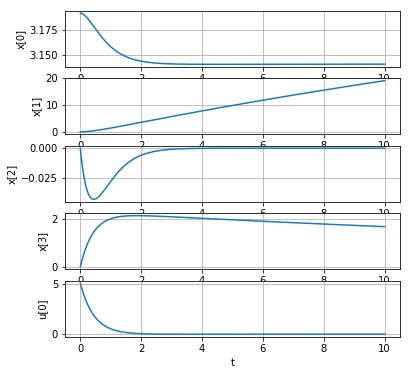

In [7]:
from inertial_wheel_pendulum import *
from IPython.display import HTML
from inertial_wheel_pendulum_visualizer import *
import matplotlib.pyplot as plt

def lqr_controller(x):
    # This should return a 1x1 u that is bounded
    # between -input_max and input_max.
    # Remember to wrap the angular values back to
    # [-pi, pi].
    #print x
    global xf, uf, K
    
    #x[1] = (x[1])%(math.pi*2)
    #x[2] = (x[2])%(math.pi*2)
    #print x- xf
    #print xf
    u = np.zeros((1, 1))
    error = x-xf;
    error[1] = (error[1])%(math.pi*2)
    if(error[1]>math.pi):
        error[1] = error[1]-2*math.pi
    
    error[0] = (error[0])%(math.pi*2)
    if(error[0]>math.pi):
        error[0] = error[0]-2*math.pi
    
    #print error
    
    ideal_control = -np.dot(K,error)
    
    if(ideal_control< -input_max ):
        u=np.array([-input_max])
    elif(ideal_control>input_max):
        u=np.array([input_max])
    else:
        u=ideal_control
    
    ''' 
    Code submission for 3.3: fill in the code below
    to use your computed LQR controller (i.e. gain matrix
    K) to stabilize the robot by setting u appropriately.
    '''
    
    return u

# Run forward simulation from the specified initial condition
duration = 10.
x0 = [3.192,0.0,0.0,0.0]
#x0 = [3, 0.0, 0.0, 5.0]
input_log, state_log = \
    RunSimulation(pendulum_plant,
              lqr_controller,
              x0=x0,
              duration=duration)

    
# Visualize state and input traces
fig = plt.figure().set_size_inches(6, 6)
for i in range(4):
    plt.subplot(5, 1, i+1)
    plt.plot(state_log.sample_times(), state_log.data()[i, :])
    plt.grid(True)
    plt.ylabel("x[%d]" % i)
plt.subplot(5, 1, 5)
plt.plot(input_log.sample_times(), input_log.data()[0, :])
plt.ylabel("u[0]")
plt.xlabel("t")
plt.grid(True)

# Visualize the simulation
viz = InertialWheelPendulumVisualizer(pendulum_plant)
ani = viz.animate(input_log, state_log, 30, repeat=True)
plt.close(viz.fig)
HTML(ani.to_html5_video())

## 3.4 LQR Region of Attraction, Prologue (2 points, 2/2 autograded)

As you probably found when playing with the LQR simulation in the previous question, there are plenty of states for which the LQR doesn't converge. **Find an x0 from which LQR does *not* converge, and an x0 from which is does, and write them below.**

In [8]:
'''
Code submission for 3.4
'''
def get_x0_does_not_converge():
    return [0.0, 0.0, 0.0, 5.0]
def get_x0_does_converge():
    return [3, 0.0, 0.0, 5.0]

## 3.5 LQR Region of Attraction, Episode 1 (5 points, 2/5 autograded)

What we would like to know is when the LQR controller will work, and when it won't. Let's see if we can analyze the region of attraction of this controller using the tools of Lyapunov stability analysis.

The closed-loop system dynamics of our system when using the LQR controller are

$$ \dot{x} = f(x, -K(x-x_f)) $$

A function that we know is a decent Lyapunov function near $x_f$ is the cost-to-go of the LQR solution: $V = \bar{x}^T S \bar{x}$.

Following section [10.3 of the textbook](http://underactuated.csail.mit.edu/underactuated.html?chapter=lyapunov), we just need to find a $\rho$ such that

$$ 
\dot{V}(x) \prec 0, \ \ \  \forall x : V(x) > 0
$$

to demonstrate the running LQR on our full (nonlinear!) system from state $x_0$ will converge as long as $V(x_0) \leq \rho$.

Let's start by calculating $\dot{V}(x)$ and $\dot{V}(x)$ for the full system. **Using the helper function *evaluate_f(x, u)* (it's a member of InertialWheelPendulum in *inertial_wheel_pendulum.py*) to fill out *calcV* and *calcVdot* to do this.**

Running this cell will populate the variables *V_samples*, *f_samples*, and *Vdot_samples* in the plane where $\theta_2 = 0$. Feel free to tweak those the sample grid (defined by n_bins, theta_widthm, etc) as you wish, but we'll be using these samples to estimate the region of attraction, so keep the resolution as high as you can while keeping the runtime reasonable. (We are, unfortunately, sampling in 3 dimensions...)

In [9]:
#where are the 3 non-autograded points coming from? Do I need to comment code or something????
import matplotlib.pyplot as plt
import time

# Calculates the closed loop f(x) at xn
def calcF(xn):
    # Feel free to bring in whatever
    # global variables you need, e.g.:
    global pendulum_plant
    global K
    global xf
    #find the LQR control
    control = lqr_controller(xn)
    #evaluate the pendulum to find \dot{x}
    return pendulum_plant.evaluate_f(control, xn)   
    
    '''
    Code submission for 3.5: populate
    this function to calculate the closed-loop
    system dynamics f(x) at the input point.
    '''
    #return np.zeros(4)

# Calculates V(xn)
def calcV(xn):
    # Feel free to bring in whatever
    # global variables you need
    '''
    Code submission for 3.5: populate
    this function to calculate V(x)
    at the input point.
    '''
    global S
    #find xbar, which here is called error
    error = xn-xf;
    
    #make sure theta1 and theta2 wrap correctly
    error[1] = (error[1])%(math.pi*2)
    if(error[1]>math.pi):
        error[1] = error[1]-2*math.pi
    
    error[0] = (error[0])%(math.pi*2)
    if(error[0]>math.pi):
        error[0] = error[0]-2*math.pi
    xbar = error
    
    #use the cost function given in the problem statement to find V(x)
    return np.dot(xbar.transpose(),np.dot(S,xbar))
    #return 0.

# Calculates \dot{V}(xn).
def calcVdot(xn):
    # Feel free to bring in whatever
    # global variables you need
    
    '''
    Code submission for 3.5: populate
    this function to calculate Vdot(x)
    at the input point.
    '''
    global S
    #find xbar, which here is called error
    error = xn-xf;
    #make sure theta1 and theta2 wrap correctly
    error[1] = (error[1])%(math.pi*2)
    if(error[1]>math.pi):
        error[1] = error[1]-2*math.pi
    
    error[0] = (error[0])%(math.pi*2)
    if(error[0]>math.pi):
        error[0] = error[0]-2*math.pi
    xbar = error
    
    #calculate f(x)
    control = lqr_controller(xn)
    func = pendulum_plant.evaluate_f(control, xn)
    
    #calculate the derivative of V(x)
    return np.dot(2*np.dot(xbar.transpose(),S),func)

    #return 0.

start_time = time.time()

# Sample f, V, and Vdot over
# a grid defined by these parameters.
# (Odd numbers are good because there'll be
# a bin at exactly the origin.
# These are slightly strange numbers as we've
# tried to default these to something as small
# as possible while still giving reasonable results.
# Feel free to increase if your computer and patience
# can handle it.)
n_bins = 41
n_bins_theta2d = 7
# For theta and thetad, we only need to span
# a small region around the fixed point
theta_width = 4
thetad_width = 4
# For \dot{theta_2}, though, the default
# parameters for our pendulum lead us to
# need to search larger absolute \dot{theta_2}
# values (because the inertial wheel is relatively
# light).
theta2d_width = 50

# Do the actual sampling....
x = np.linspace(xf[0]-theta_width, xf[0]+theta_width, n_bins)
y = np.linspace(xf[2]-thetad_width, xf[2]+thetad_width, n_bins)
z = np.linspace(xf[3]-theta2d_width, xf[3]+theta2d_width, n_bins_theta2d)
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

def calc_over_array(f):
    return np.array([[[f([dx, 0., dy, dz]) for dz in z] for dx in x] for dy in y])

V_samples = calc_over_array(calcV)
f_samples = calc_over_array(calcF)
Vdot_samples = calc_over_array(calcVdot)

elapsed = time.time() - start_time
print "Computed %d x %d x %d sampling in %f seconds" % (n_bins, n_bins, n_bins_theta2d, elapsed)

Computed 41 x 41 x 7 sampling in 1.715291 seconds


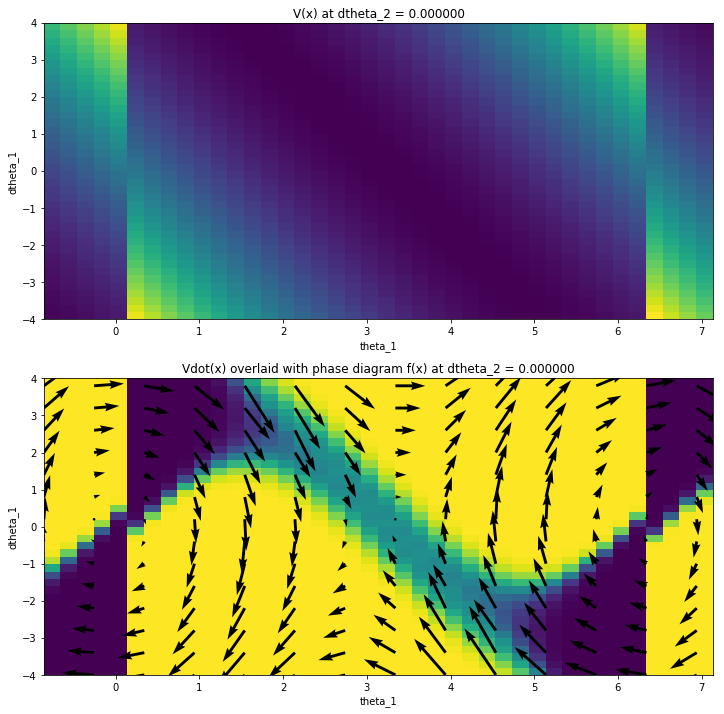

In [10]:
# This cell plots the samples using color-coded plots.
# Color coding:
#   V: blue = low-value, red = high-value
#   Vdot: blue = low value, yellow = around 0, red = high value
# The plot of Vdot is overlayed with a quiver plot of the samples
# of f.

# Select with slice of \dot{theta_2} we'll
# plot... this slice should be close to 0,
# as it's the middle bin.
theta2d_plotting_slice = n_bins_theta2d / 2

plt.figure().set_size_inches(12,12)

# Plot V
Xplot, Yplot = np.meshgrid(x, y)
plt.subplot(2, 1, 1)
plt.pcolormesh(Xplot, Yplot, V_samples[:, :, theta2d_plotting_slice])
plt.title("V(x) at dtheta_2 = %f" % z[theta2d_plotting_slice])
plt.xlabel("theta_1")
plt.ylabel("dtheta_1")

# Plot Vdot
# Use a sigmoid to try to squash the huge range of Vdot
# into something more visually appealing.
def sigmoid(x):
    return 1 / (1 + np.exp(-x/1000.))

plt.subplot(2, 1, 2)
Vdot_viz = sigmoid(Vdot_samples[:, :, theta2d_plotting_slice])
plt.pcolormesh(Xplot, Yplot, Vdot_viz, vmin=0, vmax=1.0)
plt.title("Vdot(x) overlaid with phase diagram f(x) at dtheta_2 = %f" % z[theta2d_plotting_slice])
plt.xlabel("theta_1")
plt.ylabel("dtheta_1")

# Don't plot a quiver arrow at *every* point, but instead
# every ds points
# (lower = more quiver arrows)
ds = 3
plt.quiver(Xplot[::ds, ::ds], 
           Yplot[::ds, ::ds], 
           f_samples[::ds, ::ds, 
           theta2d_plotting_slice, 0], f_samples[::ds, ::ds, theta2d_plotting_slice, 2]);

## 3.6 LQR Region of Attraction, Episode 2 (6 points, 3/6 autograded)

Now you should have access to (many samples from) your candidate $V$ and $\dot{V}$. One approach you could use from here is to estimate the region of attraction from these samples. Let's do that -- **use Theorem 10.5 from the textbook to estimate the largest region of attraction that you can for the LQR controller you derived above -- that is, find the biggest value of $\rho$ such that at every point $x_i$ where $V(x_i) \leq \rho$, $\dot{V}(x_i) \prec 0$.**

(Hint: it'll be easiest to do this by finding counterexample -- e.g., the point $x_i$ with the smallest $V(x_i)$ where $\dot{V}(x_i) \geq 0$.)

Region of attraction estimated at V(x) <=  28
Area of your region of attraction:  1.11188737539


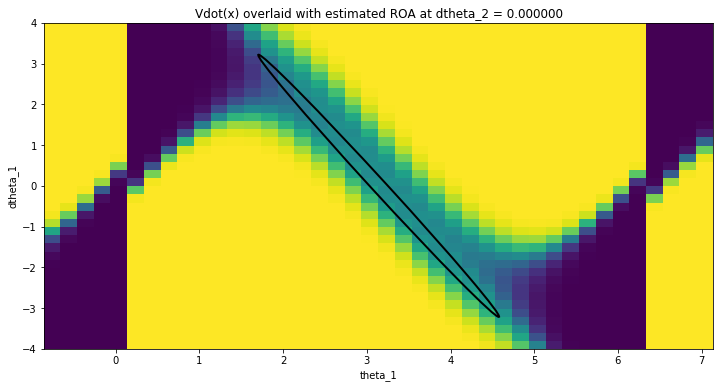

In [11]:
def estimate_rho(V, Vdot):
    '''
    Code submission for 3.6
    Fill in this function to use the samples of V and Vdot
    (Each array has dimension [n_bins, n_bins, n_bins_theta2d])
    to compute a maximal rho indicating the region of attraction
    of the fixed point at the upright.
    '''
    
    p=0
    inloop = True;
    x = 0;
    y = 0;
    z = 0;
    while inloop == True:
       
        #evaluate Vdot for points within the current level curve
        if(V[x,y,z] <= p-1) and (Vdot[x,y,z] > 0):
            rho = p; #if vdot is positive we have found the max size for this level curve given the cost func
            inloop = False; 
            
        #if we have iterated through all x,y,z increment the level curve size and try again    
        elif x== (n_bins-1) and y== (n_bins-1) and z== (n_bins_theta2d-1):
            p = p+1;
            x = 0;
            y = 0;
            z = 0;
        
        #increment to continue iterating through all the points one by one
        elif x<(n_bins-1):
           x = x+1;
        elif y<(n_bins-1):
           x=0;
           y = y+1;
        else:
           x=0;
           y=0;
           z=z+1;
            
    
    return rho

rho = estimate_rho(V_samples, Vdot_samples)
print "Region of attraction estimated at V(x) <= ", rho
#Xplot, Yplot = np.meshgrid(x, y)

# Plot Vdot again, but overlay the region of attraction -- which,
# for quadratic V, is an ellipse.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig.set_size_inches(12,6)
plt.pcolormesh(Xplot, Yplot, Vdot_viz, vmin=0, vmax=1.0)

# The part of S we care about is the 2x2 submatrix from the 1st and 3rd rows
# and columns.
S_sub = np.reshape(S[[0, 2, 0, 2], [0, 0, 2, 2]], (2, 2))
# Extract its eigenvalues and eigenvectors, which tell us
# the axes of the ellipse
ellipseInfo = np.linalg.eig(S_sub)
# Eigenvalues are 1/r^2, Eigenvectors are axis directions
axis_1 = ellipseInfo[1][0, :]
if ellipseInfo[0][0] > 0 and ellipseInfo[0][1] > 0:
    r1 = math.sqrt(rho)/math.sqrt(ellipseInfo[0][0])
    axis_2 = ellipseInfo[1][1, :]
    r2 = math.sqrt(rho)/math.sqrt(ellipseInfo[0][1])
    angle = math.atan2(-axis_1[1], axis_1[0])
    from matplotlib.patches import Ellipse
    ax.add_patch(Ellipse((xf[0], xf[2]), 
                         2*r1, 2*r2, 
                         angle=angle*180./math.pi, 
                         linewidth=2, fill=False, zorder=2));
    
    # Report an interesting number that is easy to compute
    # from the ellipse info
    print "Area of your region of attraction: ", math.pi * r1 * r2
else:
    print "S_sub had nonpositive eigenvalues. That shouldn't happen."
    
plt.title("Vdot(x) overlaid with estimated ROA at dtheta_2 = %f" % z[theta2d_plotting_slice])
plt.xlabel("theta_1")
plt.ylabel("dtheta_1");

## 3.7 LQR Region of Attraction, Intermission (3 points)

1) Is this sufficient proof that LQR *would* work starting from $x_0$ *inside* region of attraction (ignoring sampling errors)? 

2) What about the opposite -- is this sufficient proof that LQR *would not* work starting from $x_0$ *outside* of this region of attraction?

3) If you answer to (2) is No, speculate what strategies we could use to find larger regions of attraction. (For example, could changing V increase the largest ROA we could guarantee? How could we formulate search over V?)

**Short answer explanation for 3.7**

1) Yes, LQR will work for any $x_0$ inside the region of attraction, as all points within the region of attraction have a positive cost to go, $V(x)$, and a negative $\dot{V}(x)$, which shows that the cost decreases as the LQR approaches its final state.

2) No, there may be some states outside this region of attraction which are still controllable by LQR. These states may be outside of the analytically found region of attraction, but may still have a positive $V(x)$ and a negative $\dot{V}(x)$, and might result in a trajectory that only passes through other similar-states. 

3) There might be another $V(x)$ with a larger region of attaction. One way to formulate the search over $V(x)$ is to formulate the search using bilinear alternations - first one could given $V(x)$, search for $\rho$, and then given $\rho$, one could change and search for another $V(x)$, and then once another $V(x)$ is found, swap back to looking for $\rho$. In this search $V(x)$ should be constrained to be SOS and zero at the target endpoint. 

## 3.8 Combined Swing-up and Stabilization (8 points, 4/8 autograded)

Finally, we're ready for the main event! **Write a controller that will accomplish the task of swinging up the inertial pendulum to its upright fixed point from any initial condition. Your controller should use a custom swingup controller to get close to the unstable fixed point, and then switch to LQR to stay there. Use your estimated region of attraction to decide when it's safe to switch to LQR. A framework for setting up this hybrid controller is provided below for your convenience.**

To accomplish swing-up, apply energy shaping to $\theta$ via non-collocated feedback linearization. (Energy shaping for $\theta$ should follow from the simple pendulum, so you just need figure out how to use your non-collocated input $\tau$ to directly apply torque on $\theta$.)

While we'll look at your code, we'll also rely on the autograder to test your system from a variety of initial conditions. (You can try the autograder with the cell at the bottom of the notebook.) Besides the random initial conditions we'll test, we'll also check:
- $x = \left[ 0, 0, 0, 0 \right] $
- $x = \left[ \pi, 0, 0, 0 \right] $
- $x = \left[ 3\pi, 0, 0, 0 \right] $
- $x = \left[ 0, -100, 0, 0 \right] $
- $x = \left[ 0, 0, 0, 20 \right] $

Make sure you can handle these corner cases!

Solve for tau:

$$(m_1 l_1^2 + m_2 l_2^2 + I_1)\ddot{\theta_1} = -(m_1 l_1 + m_2 l_2) g sin(\theta_1)-\tau$$

$$ \tau = -(m_1 l_1 + m_2 l_2) g sin(\theta_1)-(m_1 l_1^2 + m_2 l_2^2 + I_1)\ddot{\theta_{1}}$$


Applying feedback control:

$$ \tau = -(m_1 l_1 + m_2 l_2) g sin(\theta_1)-(m_1 l_1^2 + m_2 l_2^2 + I_1)\ddot{\theta_{1}^d}$$

Results in:
$$\ddot{\theta}_2 = u$$
$$\frac{-u I_2 + (m_1 l_1+m_2 l_2)g sin(\theta)}{(m_1 l_1^2 + m_2 l_2^2 + I_1+ I_2})$$

The total energy is:
$$E = \frac{1}{2}(m_1 l_1^2 + m_2 l_2^2 + I_1 +I_2)\dot{\theta_1}^2-(m_1 l_1 + m_2 l_2) g cos(\theta_1)$$

Alternatively, we could represent the total energy as:
$$E = \frac{1}{2}(m_1 l_1^2 + m_2 l_2^2 + I_1 +I_2)\dot{\theta_1}^2 + I_2 \dot{\theta_1} \dot{\theta_2} + I_2 \dot{\theta_2}^2-(m_1 l_1 + m_2 l_2) g cos(\theta_1)$$

However, since $I_2$ is small, these additional terms can be neglected for simplicity. If I wanted to slightly improve the controller, they could be added back in.

To understand how to control the energy we take the derivative:
$$\dot{E} = (m_1 l_1^2 + m_2 l_2^2 + I_1+I_2)\dot{\theta_1}\ddot{\theta_1}+\dot{\theta}(m_1 l_1 + m_2 l_2) g sin(\theta_1)$$
$$ = (-u I_2 + (m_1 l_1+m_2 l_2)g sin(\theta))\dot{\theta_1}+\dot{\theta_1}(m_1 l_1 + m_2 l_2) g sin(\theta_1)$$
$$ = -u I_2 \dot{\theta} + 2*\dot{\theta_1}(m_1 l_1 + m_2 l_2) g sin(\theta_1)$$

Since the desired energy is constant, we can say $\dot{\tilde{E}} = \dot{E} - \dot{E_d} = \dot{E}$ and thus:
$$\dot{\tilde{E}} = -u I_2 \dot{\theta} + 2*\dot{\theta_1}(m_1 l_1 + m_2 l_2) g sin(\theta_1)$$

We want to write an equation of the form $\dot{\tilde{E}} = -k \tilde{E}$ so to do this we need to cancel out the second half of the equation above and use a u like:
$$u = -2\frac{(m_1 l_1 + m_2 l_2) g sin(\theta_1)}{I_2}+k\dot{\theta}\tilde{E}$$

Which simplifies to:

$$u = \frac{2*tauG[0]}{M[0,1]}+k*qd[0]*\tilde{E}$$

Which pushes the system to zero error, because when plugged into $\dot{\tilde{E}}$ it results in:
$$\dot{\tilde{E}} = -k I_2 \dot{\theta}^2 \tilde{E}$$

And we know I_2 and $\dot{\theta}^2$ are positive and we can set k to be positive, so this is a working control.

28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
2

28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
2

28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
2

28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
2

28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
2

28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
2

28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
2

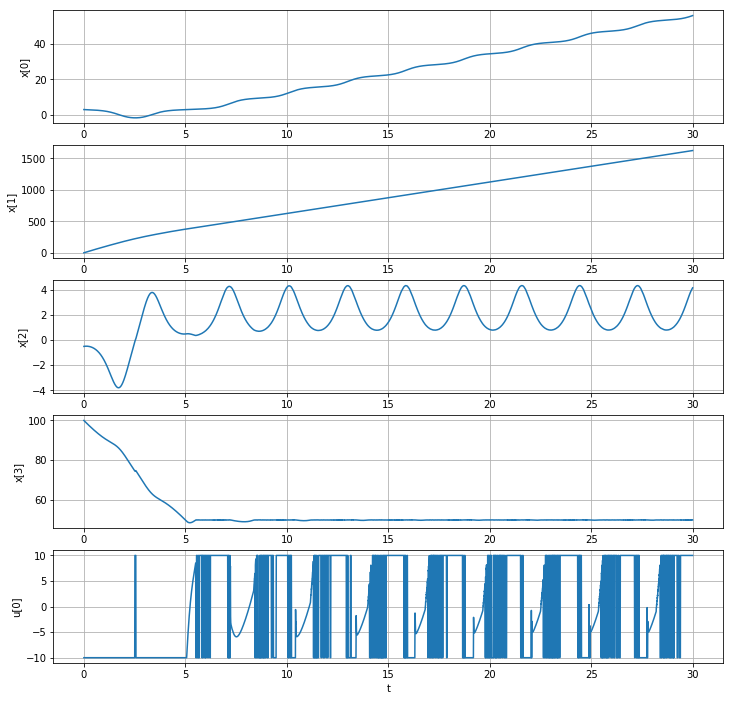

In [16]:
# The swingup controller should accept a state x,
# and return a control input u (a 1x1 numpy array)
# that respects the plant's input limits.
def swingup_controller(x):
    # Here's some useful things...
    q = x[0:2]
    qf = xf[0:2]
    qd = x[2:4]
    (M, C, tauG, B) = pendulum_plant.GetManipulatorDynamics(q, qd)
    k=10
    
    ''' 
    Code response for problem 3.8:
    Fill in this swingup controller to control the pendulum
    energy to the homonclinic orbit.
    (You'll probably want to ensure that your controller
    controls the velocity of the inertial wheel, too, using whatever
    means you think are reasonable.)
    '''
    #get the difference in current energy and desired energy at stable point at top
    Ecurr = .5*qd[0]*M[0,0]*qd[0]+pendulum_plant.GetPE(q, qd);
    Emax = pendulum_plant.GetPE(qf, qd);
    Etilde = Ecurr-Emax;
    
    u = np.array([0.])
   
    if(Etilde < Emax/2 and abs(qd[0]) <0.1):
        #if stuck at a difficult to control point with low energy, just spin the wheel at max to get somewhere else
        ideal_control = input_max;
        #print "ahhh"
    elif(qd[1]>50): #if wheel is spinning too fast slow it down
        ideal_control = -input_max;
    elif (qd[1]<-50):#if wheel is spinning too fast slow it down
        ideal_control = input_max;
    else:
        #if in a reasonable spot to control, implement the derived control
        ideal_control = (2*tauG[0]/ M[0,1])+k*qd[0]*Etilde; 
    
    #make sure the control is not outside of the feasible range
    if(ideal_control< -input_max ):
        u=np.array([-input_max])
    elif(ideal_control>input_max):
        u=np.array([input_max])
    else:
        u=ideal_control
    return u

def combined_controller(x):
    ''' 
    Code response for problem 3.8:
    Fill in this combined controller to dispatch to either the
    swingup or lqr controller by checking the state against your
    calculated region of attraction.
    '''
    global rho
    print(rho)
    u = np.array([0.])
    #print rho
    #print calcV(x)
    
    if calcV(x) < rho:
        #check if in an LQR-controllable state
        #print "in lqr!"
        u[0] = lqr_controller(x)
    else:
        u[0] = swingup_controller(x)
    
    return u

# Simulate!
x0 = [3.0, 0.0, -0.5, 100.]
#x0 = [0.0, 0.0, 0.0, 0.0]
duration = 30
input_log, state_log = RunSimulation(pendulum_plant,
                        combined_controller,
                        x0 = x0,
                        duration = duration)

# Plot traces of the results
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(12,12)
for i in range(4):
    plt.subplot(5, 1, i+1)
    plt.plot(state_log.sample_times(), state_log.data()[i, :])
    plt.grid(True)
    plt.ylabel("x[%d]" % i)
plt.subplot(5, 1, 5)
plt.plot(input_log.sample_times(), input_log.data()[0, :])
plt.ylabel("u[0]")
plt.xlabel("t")
plt.grid(True)

In [15]:
from IPython.display import HTML
from inertial_wheel_pendulum_visualizer import *

viz = InertialWheelPendulumVisualizer(pendulum_plant)
ani = viz.animate(input_log, state_log, 30, repeat=True)
plt.close(viz.fig)
HTML(ani.to_html5_video())

# 4. Sum-of-squares verification for wheel pendulumn

In the following, we will first walk you through an example that uses sum-of-squares optimization to verify the global stability of a dampled pendulumn. Then we will ask you to verify the stability of the derived LQR controller on the wheel pendulumn.

## 4.1 Sos verification for the dampled pendulumn (4 points)

The mechanical energy provides a simple intuition for us to discuss the stability of the dampled pendulumn. However, it might not work for more complex systems. To provide a more principled solution, we could find a Lyapunov function for non-linear systems using sum-of-square optimization. The sum-of-square optimization can be converted into semi-definite programming (SDP), which is a special form of convex optimization and can be solved to optimality. Before working on this problem, you should take a look at the `mathematical_program_and_sos_examples.ipynb` to understand the API of `MathematicalProgram`.

Following is the code for finding a Lyapunov function to verify the stability of the damped pendulumn using sum-of-squares optimization. It basically solves an SoS with respect to the following three constraints (let's assume $x_0$ is the fixed point at the bottom):

- $V$ is strictly positive when the state is away from $x_0$.
- $\dot{V}$ is strictly negative away from $x_0$ (except for the fixed point at the top).
- $V$ should be $0$ at $x_0$.


For more details, please see example 10.3 in the [textbook](http://underactuated.csail.mit.edu/underactuated.html?chapter=lyapunov).

Play with the code and answer the following questions:

1) Explain the functionality of the term ```eps*(x-x0).dot(x-x0)``` used in ```contraint1```.

2) We multiply ```s**2``` with ```eps*(x-x0).dot(x-x0)``` in ```constraint2```. What will happen if we remove the term ```s**2``` and why?


**Answer for 4.1**

1) Since we want V(x) to be positive everywhere outside of the origin we need to make sure the SOS formulation of V can only be zero at the origin. eps*(x-x0).dot(x-x0) is a very gradual slope up from 0 at x0, making it a good choice as it allows V(x) to be zero at x0 and forces V(x) to be strictly positive when not at x0. By adding in this constraint we can guard against numerical errors in numbers close to zero.

2) The second bulleted constraint lists that $\dot{V}$ is required to be strictly negative away from $x_0$ (execpt at the fixed point at the top). The fixed point at the top occurs when $\theta = \pi$ and thus $\sin(\theta_{top}) = 0$. Since we want to add the ability for $\dot{V}$ to be zero at the top without changing the sign of this bounding term, we square $\sin(\theta)$ to make sure it is always positive. Removing this term causes the kernel to die when the code is run, as the problem is in feasible to solve.

In [14]:
import numpy as np
from pydrake.all import MathematicalProgram, Solve, Variables
from pydrake.symbolic import Polynomial
from pydrake.examples.pendulum import PendulumParams

# Define mathematical program
prog = MathematicalProgram()

# Using the default pendulum parameters
# mass = 1.0 kg
# length = 0.5 m
# dampling = 0.1 kg m^2/s
# gravity = 9.81 m/s^2
p = PendulumParams()

# Define sin(theta)
s = prog.NewIndeterminates(1, 's')[0]
# Define cos(theta)
c = prog.NewIndeterminates(1, 'c')[0]
# Define thetadot
thetadot = prog.NewIndeterminates(1, 'thetadot')[0]
# Construct state x
x = np.array([s, c, thetadot])
# Define the second-order derivative of the system
f = [ c*thetadot, -s*thetadot, (-p.damping()*thetadot - p.mass()*p.gravity()*p.length()*s)/(p.mass()*p.length()*p.length())]

# Define the equilibrium point at the bottom
x0 = np.array([0, 1, 0])
eps = 1e-4

deg_V = 2
# Lyapunov function
V = prog.NewFreePolynomial(Variables(x), deg_V).ToExpression()
# V is strictly positive away from x0
constraint1 = V - eps*(x-x0).dot(x-x0)
prog.AddSosConstraint(constraint1)

# Derivative of the Lyapunov function
Vdot = V.Jacobian(x).dot(f)

deg_L = 2;
L = prog.NewFreePolynomial(Variables(x), deg_L).ToExpression()
# Vdot is strictly negative away from x0
constraint2 =  -Vdot - L*(s**2+c**2-1) - eps*(x-x0).dot(x-x0)*s**2 
prog.AddSosConstraint(constraint2)

# Add V(x0) = 0 constraint
constraint3 = V.Substitute({s: 0, c: 1, thetadot: 0}) == 0
prog.AddLinearConstraint(constraint3)

# Solve it
result = Solve(prog)
print 'Is the solving success? ', result.is_success()
print('V =')
Vsol = Polynomial(result.GetSolution(V));
print(Vsol.RemoveTermsWithSmallCoefficients(1e-6))

print('Mechanical Energy = ')
print(.5*p.mass()*p.length()**2*thetadot**2 - p.mass()*p.gravity()*p.length()*c)

Is the solving success?  True
V =
0.20003117459019445*c(0)^2 + -0.40005446200121264*c(0) + 0.20002335832611745*1 + 0.00079639362191912639*s(0) * thetadot(0) + 0.19233678026647755*s(0)^2 + 0.010054905511636384*thetadot(0)^2
Mechanical Energy = 
( - 4.9050000000000002 * c(0) + 0.125 * pow(thetadot(0), 2))


We then map the derived Lyapunov function back to the original coordinate space and visualize as a countour plot, which looks a lot like mechanical energy.

In [15]:
%matplotlib notebook  
import matplotlib.pyplot as plt

# Plot the results
nq = 151
nqd = 151
q = np.linspace(-2*np.pi, 2*np.pi, nq)
qd = np.linspace(-2*p.mass()*p.gravity()*p.length(), 2*p.mass()*p.gravity()*p.length(), nqd)
Q, QD = np.meshgrid(q, qd)
Z = Q.copy()
env = {s: 0., c: 1., thetadot: 0}
for i in range(nq):
    for j in range(nqd):
        env[s] = np.sin(Q[i, j])
        env[c] = np.cos(Q[i, j])
        env[thetadot] = QD[i, j]
        Z[i, j] = Vsol.Evaluate(env)
    
#plt.rc('text', usetex=True)
fig, ax = plt.subplots()
ax.contour(Q,QD,Z)
ax.set_xlabel('theta')
ax.set_ylabel('thetadot')
ax.set_title('V')

plt.savefig("pend_global_sos.svg")

<IPython.core.display.Javascript object>

## 4.2 Bonus Question: Sum-of-square verification of wheel pendulum (5 points)

In this problem, you will apply the sum-of-square optimization to verifiy the region of attraction obtained in Problem 3.6, and the verified close-loop system contains the LQR controller you implemented. The original system has torque limits. In this problem, we remove the torque limit for the simplicity of your implementation.

You have already seen the re-parameterization of $\theta$ into sin$(\theta)$ and cos$(\theta)$ in the above pendulumn example. However, the LQR controller for the system requires the angle $\theta$ as part of the state. Thus, we use higher-order Taylor expansion of sin$(\theta)$ around the fixed point as an approximation of the true dynamics.

In [16]:
def sin_taylor_around_pi(t, order):
    '''
    Approximates the sine function around pi using Taylor series.
    '''
    if order < 1:
        raise ValueError('The order of the Taylor expansion must be at least 1.') 
    a = (t - np.pi)
    s = - a
    for i in range(1, (order+1)/2):
        a *= -1 * (t-np.pi)**2 / ((2*i) * (2*i+1))
        s -= a
    return s

In [17]:
# Plot the talyor approximation
import matplotlib.pyplot as plt
t = np.linspace(-np.pi, 3*np.pi)
fig = plt.figure()
plt.plot(t, np.sin(t))
plt.plot(t, sin_taylor_around_pi(t, 5))
plt.ylim(-1.,1.)

<IPython.core.display.Javascript object>

(-1.0, 1.0)

The cell below initializes the optimization problem and prepares several dynamic terms. Note that the angle of the pendulum in this problem is relative to the top position (the fixed point), which will make solver more stable to numerical errors. Before working on this problem, you should take a look at the `mathematical_program_and_sos_examples.ipynb` to understand the API of `MathematicalProgram`.

You should skim through this cell but you don't need to modify any code in it.

In [18]:
from pydrake.all import MathematicalProgram, Variables, SolutionResult, Solve

# intializion of the optimization problem
prog = MathematicalProgram()

# Reduced state of the system as a set of indeterminates
# for the SOS verification
# x[0] = angle of the pendulum relative to np.pi (the fixed point)
# x[1] = velocity of the pendulum
# x[2] = velocity of the wheel
nx = 3
x = prog.NewIndeterminates(nx, 'x')
x_eq = np.array([np.pi, 0., 0.])

# The dynamic of the pendulum
M = np.array([
    [m1*l1**2 + m2*l2**2 + pendulum_plant.I1 + pendulum_plant.I2, pendulum_plant.I2],
    [pendulum_plant.I2, pendulum_plant.I2]
])
C = np.array([
    [0, 0],
    [0, 0]
])
B = np.array([
    [0.],
    [1.]
])

# The torque caused by gravity. Note that the taylor approximation is used here
order_sine = 5
tauG = np.array([
    -(m1*l1 + m2*l2)*g*sin_taylor_around_pi(x[0]+x_eq[0], order_sine),
    0.
])

# lqr solution
print(K.shape)
print(S.shape)
K_reduced_sos = np.delete(K, (1), axis=1)
print(K_reduced_sos)
S_reduced_sos = np.delete(np.delete(S, (1), axis=0), (1), axis=1)

# closed-loop dynamics in the form x_dot = f(x)
xdot = np.concatenate([
    [x[1]],
    np.linalg.inv(M).dot(-C.dot(x[1:3]) + tauG - B.dot(K_reduced_sos).dot(x)),
])

(1, 4)
(4, 4)
[[-101.516  -45.519   -0.032]]


In the cell below, you need to add a contraint to the optimization problem to ensure the time derivate of the Lyapunov function is negative. You might take a look at example 10.7 of the [textbook](http://underactuated.csail.mit.edu/underactuated.html?chapter=lyapunov). This question will be graded manually.

In [19]:
# LQR cost-to-go as Lyapunov function
V = .5*x.dot(S_reduced_sos).dot(x)

# time derivative of the Lyapunov function
Vdot = x.dot(S_reduced_sos).dot(xdot)

# for S-procedure
lambda_degree = 4
(lambda_sos, constraint) = prog.NewSosPolynomial(Variables(x), lambda_degree)

# Replace with the result you obtained in Problem 3.6
#V_roa_from_sampling = 100.0

# Add a constraint to ensure the time derivative of 
# the Lyapunov function should be negative
# If you leave the following contraint empty, the optimization has trivial solution, which is not meaningful.

###Sample from last problem
#deg_L = 2;
#L = prog.NewFreePolynomial(Variables(x), deg_L).ToExpression()
## Vdot is strictly negative away from x0
#constraint2 =  -Vdot - L*(s**2+c**2-1) - eps*(x-x0).dot(x-x0)*s**2 
#prog.AddSosConstraint(constraint2)
### YOUR CODE HERE
#eps = 1e-4
#xf = np.array([math.pi, 0, 0])
#print x-xf

#estimate region of attraction
rho = estimate_rho(V_samples, Vdot_samples)

#make sure within region of attraction is stable 
constraint2 = -Vdot -lambda_sos.ToExpression()*(rho-V)-eps*(x-xf).dot(x-xf)
prog.AddSosConstraint(constraint2)
### END OF YOUR CODE

# Solve it
result = Solve(prog)
if result.is_success():
    print 'The stability of your close-loop system is verified!'
else:
    print 'The verification is not successful, you might need some modification.'

ValueError: operands could not be broadcast together with shapes (3,) (4,) 

## Test your own implementations

Running the cell below will run your implemented functions against unit tests.

Don't change the cell below, or the test_set_3.py file. We will grade your implementations against the original files.

Make sure to SAVE your notebook before running tests. (File --> Save and Checkpoint, or use the hotkey which should be ctrl+s on linux, cmd+s on osx, etc)

**Warning: these take a little while to run, so run them sparingly!** (They test your code by testing the inertial pendulum from lots of initial conditions...) You can speed it up a little by decreasing the time it takes to run every part of the notebook (e.g. sample V less frequently in 3.5, simulate plants for a shorter duration.)

In [ ]:
import os
# Run the test in a subprocess, to make sure it doesn't open any plots...
os.popen("python test_set_3.py ./ test_results.json")

# Print the results json for review
import test_set_3
print test_set_3.pretty_format_json_results("test_results.json")

## Feedback Survey

We'd really appreciate your feedback on this set, and on the class so far! Anonymous survey [available here](https://goo.gl/forms/gSqeSnMdY8WHeCiC2).